## Block Failure Algorithm

In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
from scipy.stats import bernoulli
import numpy as np
import matplotlib.pyplot as plt
from pymc3.gp.util import plot_gp_dist
import datetime

In [2]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def scale_x(x, k, x0, y0):
    return k*(x-x0) + np.log(y0/(1-y0)) 

def scale_map(x_pia, params):
    x_pia_belief = scale_x(x_pia, params['k'], params['x0'], params['y0'])
    return -params['A']*2*(invlogit(x_pia_belief)-0.5) 

def sim_peak(N, A, shift, width):
    t = np.array(range(N))
    return A*np.exp(-((t-shift)/width)**2)    

def failure_rate(r, WIN):
    return np.convolve(r, np.ones(WIN)/WIN, mode='valid') 

def get_failures(r):
    result_df = pd.DataFrame({'failure': r})
    a = result_df['failure'].shift().eq(0)
    b = a.cumsum()
    result_df['failure_index'] = b.sub(b.mask(a).ffill().fillna(0)).astype(int)
    result_df = result_df.loc[result_df['failure'].values == 1]
    result_df = result_df.assign(grp = 1)
    return result_df 

def kaplan_meier_fit(df):
    kmf = KaplanMeierFitter()
    kmf.fit(df['failure_index'], event_observed = df['failure'])
    return kmf

def get_deltas(df, kmf, params):
    p = kmf.predict(df['failure_index'].values)
    deltas = scale_map(p, params)
    df = df.assign(deltas = np.array(deltas))
    df = df.assign(exp_deltas = np.exp(df['deltas'].values))
    return df 

def get_blocksizes(df, base_block_size, upr_bnd = 50):
    s = base_block_size*np.ones(len(df))

    for k in range(1,len(s)):
        s[k] = s[k-1]*df['exp_deltas'].values[k]
        s[k] = upr_bnd if s[k] > upr_bnd else s[k]

    result_df = df.assign(block_size = s)  
    result_df.reset_index(inplace=True) 
    return result_df

def format_output(df, N, base_block_size): 
    ind = pd.DataFrame({'index': np.array(range(N))})
    result_df = ind.merge(df, on='index', how='left')
    result_df.drop(columns=['failure', 'grp', 'deltas', 'exp_deltas'], inplace = True)
    result_df.loc[0, 'block_size'] = base_block_size
    result_df.loc[0, 'failure_index'] = 1
    result_df = result_df.fillna(method='ffill')
    return result_df

### Block Simulations

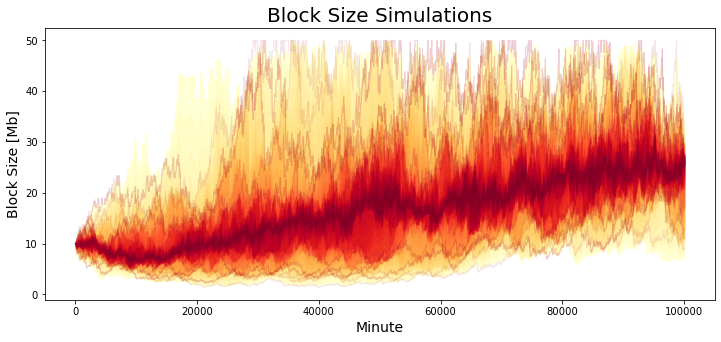

In [3]:
N = 100000
params = {}
params['A'] = 0.05
params['k'] = 10
params['x0'] = 0.5
params['y0'] = 0.5

p = 0.02
r = bernoulli.rvs(p, size=N)
failures_df = get_failures(r)
kmf = kaplan_meier_fit(failures_df)
deltas_df = get_deltas(failures_df, kmf, params)
block_sizes_df = get_blocksizes(deltas_df, 10)
block_sizes = format_output(block_sizes_df, N, 10)    
sim = block_sizes['block_size'].values.reshape(-1,1)

for k in range(1,25):
    
    r = bernoulli.rvs(p, size=N)
    failures_df = get_failures(r)
    kmf = kaplan_meier_fit(failures_df)
    deltas_df = get_deltas(failures_df, kmf, params)
    block_sizes_df = get_blocksizes(deltas_df, 10)
    block_sizes = format_output(block_sizes_df, N, 10)    
    
    blk_sizes = block_sizes['block_size'].values.reshape(-1,1)
    sim = np.hstack((sim,blk_sizes))
    print('Simulation {}'.format(k), end='\r')
    
start = datetime.datetime(2020, 3, 4, 0, 0, 0)
date_times = np.array([start + datetime.timedelta(minutes=i) for i in range(N)])      
    
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plot_gp_dist(ax, sim.transpose(), np.array(range(N)), palette="YlOrRd")
plt.ylabel("Block Size [Mb]", fontsize=14)
plt.xlabel("Minute", fontsize=14)
plt.title("Block Size Simulations", fontsize=20)
fig.savefig('blk_size_simulations.png')

### Simulate probability of failure signature
* Using this signature, bernoulli simulation trials were generated
* These trials were fed through the Block Failure Algorithm

Text(0.5, 0, 'Block #')

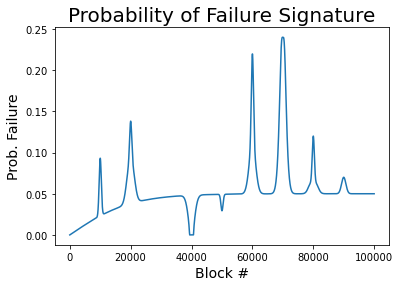

In [4]:
N = 100000
p = 0.05

params = {}
params['A'] = -p
params['k'] = 10/N
params['x0'] = 0
params['y0'] = 0.5

x_pia = np.arange(0,N,1)
fr = scale_map(x_pia, params)

#fr = np.repeat(p, N)
nPeaks = np.random.choice(np.array(range(20,30)))
for k in range(nPeaks):
    pSign = np.random.choice([-1,1], p=[0.3,0.7])
    pA = np.random.choice(np.array(range(1,10)))
    pShift = np.random.choice(np.array(range(1,10)))
    pVar = np.random.choice(np.array(range(1,4)))
    fr = fr + pSign*sim_peak(N, pA*0.01, pShift*10000, pVar*500)
       
fr = fr.clip(min=0)    
fig, ax = plt.subplots(1, 1)
ax.plot(x_pia, fr)
plt.title('Probability of Failure Signature', fontsize=20)
plt.ylabel('Prob. Failure', fontsize=14)
plt.xlabel('Block #', fontsize=14)

### Run Block Failure Algorithm
* Use Bernouli simulation above and run through algorithm

Text(0.5, 0, 'Block #')

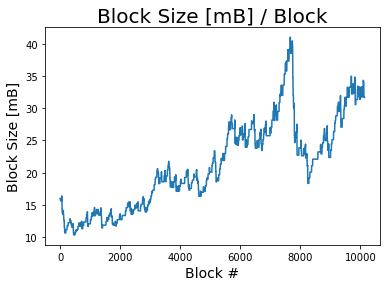

In [5]:
params = {}
params['A'] = p
params['k'] = 10
params['x0'] = 0.5
params['y0'] = 0.5

r = np.array([bernoulli.rvs(fr[k]) for k in range(N)])

failures_df = get_failures(r)
failures_df = failures_df[-500:]
kmf = kaplan_meier_fit(failures_df)
deltas_df = get_deltas(failures_df, kmf, params)
block_sizes_df = get_blocksizes(deltas_df, 16)
block_sizes = format_output(block_sizes_df, N, 16)
ind = block_sizes_df['index'].values[0]
block_sizes = block_sizes[ind:]

fig, ax = plt.subplots(1, 1)
ax.plot(block_sizes['block_size'].values, label='deltas')
plt.title('Block Size [mB] / Block', fontsize=20)
plt.ylabel('Block Size [mB]', fontsize=14)
plt.xlabel('Block #', fontsize=14)

### Simulate failures and run algorithm

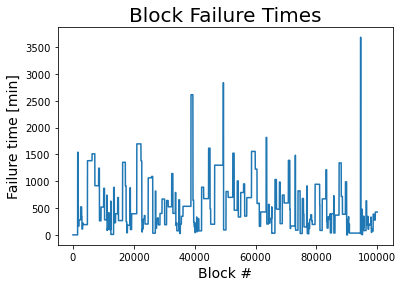

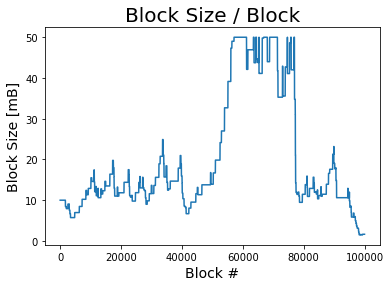

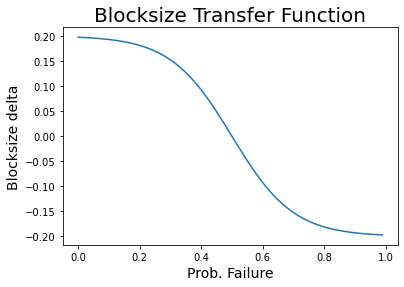

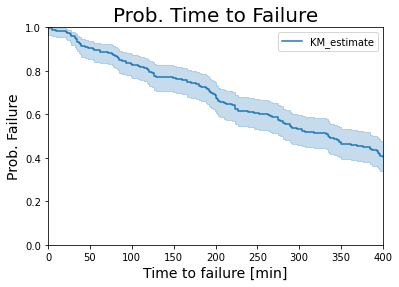

In [6]:
N = 100000
params = {}
params['A'] = 0.2
params['k'] = 10
params['x0'] = 0.5
params['y0'] = 0.5
p = 0.002

r = bernoulli.rvs(p, size=N)
failures_df = get_failures(r)
kmf = kaplan_meier_fit(failures_df)
deltas_df = get_deltas(failures_df, kmf, params)
block_sizes_df = get_blocksizes(deltas_df, 10)
block_sizes = format_output(block_sizes_df, N, 10)

x_pia = np.arange(0,1,0.01)

fig, ax = plt.subplots(1, 1)
ax.plot(block_sizes['failure_index'].values, label='deltas')
plt.title('Block Failure Times', fontsize=20)
plt.ylabel('Failure time [min]', fontsize=14)
plt.xlabel('Block #', fontsize=14)

fig, ax = plt.subplots(1, 1)
ax.plot(block_sizes['block_size'].values, label='deltas')
plt.title('Block Size / Block', fontsize=20)
plt.ylabel('Block Size [mB]', fontsize=14)
plt.xlabel('Block #', fontsize=14)

fig, ax = plt.subplots(1, 1)
ax.plot(x_pia, scale_map(x_pia, params))
plt.title('Blocksize Transfer Function', fontsize=20)
plt.xlabel('Prob. Failure', fontsize=14)
plt.ylabel('Blocksize delta', fontsize=14)

fig, ax = plt.subplots(1, 1)
ax = kmf.plot(xlim=(0, 400), ylim=(0, 1))
plt.title('Prob. Time to Failure', fontsize=20)
plt.ylabel('Prob. Failure', fontsize=14)
plt.xlabel('Time to failure [min]', fontsize=14)

mu = np.mean(deltas_df['exp_deltas'].values)
sig = np.var(deltas_df['exp_deltas'].values)

print('Simulation {} {}'.format(mu,sig), end='\r')